In [38]:
import os
import sys
project_dir = os.path.join(os.pardir, os.pardir)
sys.path.append(project_dir)

import dotenv
dotenv_path = os.path.join(project_dir, '.env')
dotenv.load_dotenv(dotenv_path)

from IPython.display import display

import importlib
import glob
import time
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import osmnx as ox
from src.data import processing_func

pd.options.display.max_columns = 50
pd.options.display.max_rows = 1000

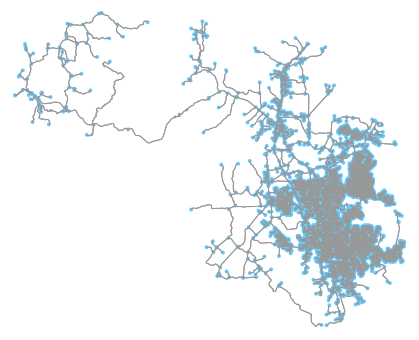

,highway,osmid,ref,x,y,geometry
274063877,NaN,274063877,NaN,-48.8163,-26.3918,POINT (-48.8162692 -26.3918219)
597508643,NaN,597508643,NaN,-49.2133,-26.1691,POINT (-49.2133184 -26.1691181)
597508666,NaN,597508666,NaN,-49.1707,-26.1875,POINT (-49.1707333 -26.1875192)
597509184,NaN,597509184,NaN,-49.0958,-26.2085,POINT (-49.0958145 -26.2084711)
601487382,NaN,601487382,NaN,-48.9031,-26.2873,POINT (-48.9030838 -26.2872981)


,access,bridge,geometry,highway,junction,key,lanes,length,maxspeed,name,oneway,osmid,ref,service,tunnel,u,v,width
0,NaN,NaN,"LINESTRING (-48.8079739 -26.3668993, -48.80799...",residential,NaN,0,NaN,32.577,NaN,Rua Mato Grosso do Sul,False,166708221,NaN,NaN,NaN,1781596160,2712030379,NaN
1,NaN,NaN,"LINESTRING (-48.8079739 -26.3668993, -48.80787...",residential,NaN,0,NaN,165.663,NaN,Rua Mato Grosso do Sul,False,166708221,NaN,NaN,NaN,1781596160,1781596141,NaN
2,NaN,NaN,"LINESTRING (-48.8079739 -26.3668993, -48.80763...",residential,NaN,0,NaN,34.044,NaN,Rua Vilmar da Silva,False,166708230,NaN,NaN,NaN,1781596160,4331763612,NaN
3,NaN,NaN,"LINESTRING (-48.8079739 -26.3668993, -48.80867...",residential,NaN,0,NaN,69.976,NaN,Rua Vilmar da Silva,False,166708230,NaN,NaN,NaN,1781596160,1808444244,NaN
4,NaN,NaN,"LINESTRING (-48.8083837 -26.3621753, -48.80847...",residential,NaN,0,NaN,163.247,NaN,Rua Espírito Santo,False,166708219,NaN,NaN,NaN,1781596162,1808444235,NaN


In [2]:
#Create Joinville polygon
joinville_polygon = "-48.802 -26.13,-48.883 -26.107,-49.161 -26.059,-49.224 -26.103,-49.239 -26.178,-49.245 -26.306,-49.043 -26.358,-48.923 -26.41,-48.898 -26.444,-48.858 -26.438,-48.802 -26.395,-48.727 -26.354,-48.746 -26.285,-48.802 -26.13,-48.802 -26.13,-48.802 -26.13,-48.802 -26.13,-48.802 -26.13,-48.802 -26.13,-48.802 -26.13,-48.802 -26.13,-48.802 -26.13"
joinville_polygon = joinville_polygon.split(",")
joinville_polygon = [(float(coord.split(" ")[0]), float(coord.split(" ")[1])) for coord in joinville_polygon]
joinville_polygon = Polygon(joinville_polygon)

#Retrieve osm data from polygon
G = ox.graph_from_polygon(joinville_polygon, network_type='drive')
ox.plot_graph(G)

gdf_nodes, gdf_edges = ox.save_load.graph_to_gdfs(G)
display(gdf_nodes.head())
display(gdf_edges.head())

In [3]:
print("Types of highway:")
gdf_edges.highway.apply(pd.Series).fillna("Guilherme")[0].value_counts()

Types of highway:


residential       23434
tertiary           3860
primary            2105
secondary          1813
unclassified        881
primary_link        161
living_street       123
motorway             96
motorway_link        86
secondary_link       51
tertiary_link        39
dummy                 2
Name: 0, dtype: int64

In [46]:
def split_df_list(gdf,target_column):
    """ df = dataframe to split,
    target_column = the column containing the values to split
    separator = the symbol used to perform the split
    returns: a dataframe with each entry for the target column separated, with each element moved into a new row. 
    The values in the other columns are duplicated across the newly divided rows.
    """
    crs = gdf.crs
    row_accumulator = []
    
    def split_list_to_rows(row):
        split_row = row[target_column] if type(row[target_column]) is list else [row[target_column]] 
        for s in split_row:
            new_row = row.to_dict()
            new_row[target_column] = s
            row_accumulator.append(new_row)    

    for index, row in gdf.iterrows():
        split_list_to_rows(row)
        
    new_df = pd.DataFrame(row_accumulator)
    new_gdf = gpd.GeoDataFrame(new_df, crs=crs)
    return new_gdf

def filter_primary(df, class_list):
    filtered_df = df.loc[df.highway.isin(class_list)]
    return filtered_df

major_gdf_edges = (gdf_edges
                   .pipe(split_df_list, target_column="highway")
                   .pipe(filter_primary, class_list=["primary", "secondary", "tertiary", "motorway"])
                   .reset_index()
                   .drop_duplicates(subset="index")
                   .drop("index", axis=1)
                   .reset_index(drop=True)
                  )
  
display(major_gdf_edges.shape)
display(major_gdf_edges.sample(5))  

(7881, 18)

,access,bridge,geometry,highway,junction,key,lanes,length,maxspeed,name,oneway,osmid,ref,service,tunnel,u,v,width
1165,NaN,NaN,"LINESTRING (-48.8136534 -26.3618307, -48.81411...",secondary,NaN,0,2,46.232,NaN,Rua Boehmerwald,False,264380737,NaN,NaN,NaN,1781669483,1407782810,NaN
356,NaN,NaN,"LINESTRING (-48.8512823 -26.2843185, -48.85193...",secondary,NaN,0,2,64.722,60,Rua Benjamin Constant,False,456609209,NaN,NaN,NaN,1111756292,1327889579,NaN
1951,NaN,NaN,"LINESTRING (-48.7998085 -26.2713355, -48.79969...",tertiary,NaN,0,2,14.210,NaN,Rua Ponte Serrada,False,359361267,NaN,NaN,NaN,1270297390,1270297469,NaN
5702,NaN,NaN,"LINESTRING (-48.8257655 -26.210424, -48.825302...",tertiary,NaN,0,2,70.824,NaN,Avenida Júpiter,False,270734478,NaN,NaN,NaN,2624304992,2624305011,NaN
750,NaN,NaN,"LINESTRING (-48.8522003 -26.3263073, -48.85218...",tertiary,NaN,0,2,81.233,NaN,Rua São Roque,False,253275301,NaN,NaN,NaN,2000688767,2000688792,NaN


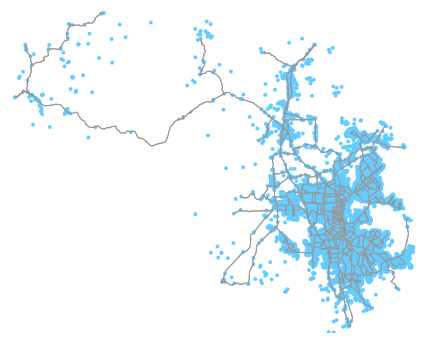

(<matplotlib.figure.Figure at 0x7f8267ed3f60>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f82756a6d30>)

In [47]:
major_traffic_network = ox.save_load.gdfs_to_graph(gdf_nodes=gdf_nodes, gdf_edges=major_gdf_edges)
ox.plot_graph(major_traffic_network)

Get Waze data:

In [34]:
#Connection and initial setup
DATABASE = {
'drivername': os.environ.get("db_drivername"),
'host': os.environ.get("db_host"), 
'port': os.environ.get("db_port"),
'username': os.environ.get("db_username"),
'password': os.environ.get("db_password"),
'database': os.environ.get("db_database"),
}

importlib.reload(processing_func)
meta = processing_func.connect_database(DATABASE)

geo_jams = processing_func.extract_geo_jams(meta, skip=50000, limit=20000)
geo_jams.head()

,uuid,pub_utc_date,street,delay,speed,speed_kmh,length,level,line,datafile_id,jams_line_list,jams_line_UTM,linestring,LonDirection,LatDirection,MajorDirection
0,456708900,2018-03-23 16:31:13.478,Eixo Industrial Hans Dieter Schmidt,149,None,13.35,727,3,"[{'x': -48.878821, 'y': -26.256729}, {'x': -48...",2401,"[(-48.878821, -26.256729), (-48.878731, -26.25...","[(711848.7661445187, 7094149.17688871), (71185...",LINESTRING (711848.7661445187 7094149.17688871...,Leste,Norte,Leste/Oeste
1,456708900,2018-03-23 16:31:13.478,Eixo Industrial Hans Dieter Schmidt,94,None,25.11,1206,2,"[{'x': -48.883364, 'y': -26.255464}, {'x': -48...",2391,"[(-48.883364, -26.255464), (-48.882837, -26.25...","[(711397.2074677314, 7094296.759902958), (7114...",LINESTRING (711397.2074677314 7094296.75990295...,Leste,Norte,Leste/Oeste
2,456708900,2018-03-23 16:31:13.478,Eixo Industrial Hans Dieter Schmidt,91,None,25.52,1206,2,"[{'x': -48.883364, 'y': -26.255464}, {'x': -48...",2389,"[(-48.883364, -26.255464), (-48.882837, -26.25...","[(711397.2074677314, 7094296.759902958), (7114...",LINESTRING (711397.2074677314 7094296.75990295...,Leste,Norte,Leste/Oeste
3,456708900,2018-03-23 16:31:13.478,Eixo Industrial Hans Dieter Schmidt,148,None,19.09,1206,3,"[{'x': -48.883364, 'y': -26.255464}, {'x': -48...",2392,"[(-48.883364, -26.255464), (-48.882837, -26.25...","[(711397.2074677314, 7094296.759902958), (7114...",LINESTRING (711397.2074677314 7094296.75990295...,Leste,Norte,Leste/Oeste
4,456708900,2018-03-23 16:31:13.478,Eixo Industrial Hans Dieter Schmidt,132,None,20.59,1206,3,"[{'x': -48.883364, 'y': -26.255464}, {'x': -48...",2395,"[(-48.883364, -26.255464), (-48.882837, -26.25...","[(711397.2074677314, 7094296.759902958), (7114...",LINESTRING (711397.2074677314 7094296.75990295...,Leste,Norte,Leste/Oeste


Merge Waze jams and OSM

In [48]:
importlib.reload(processing_func)
allocated_jams = processing_func.allocate_jams(geo_jams, major_gdf_edges, small_buffer=10, big_buffer=20, network_directional=True)
display(allocated_jams.shape)
display(allocated_jams.head())

(123580, 43)

,LatDirection,LonDirection,MajorDirection,access,big_polygon,big_polygon_left,big_polygon_right,bridge,datafile_id,delay,direction_left,direction_right,geometry,highway,index_right,jams_line_UTM,jams_line_list,junction,key,lanes,length_left,length_right,level,line,linestring,maxspeed,name,oneway,osmid,pub_utc_date,ref,service,small_polygon,small_polygon_left,small_polygon_right,speed,speed_kmh,street,tunnel,u,uuid,v,width
0,Norte,Leste,Leste/Oeste,NaN,NaN,"POLYGON ((711857.7475173461 7094168.927236637,...","POLYGON ((712426.4330559667 7094379.00103987, ...",NaN,2401,149,Leste,Oeste,LINESTRING (712490.4262859781 7094455.11686557...,primary,3385.0,"[(711848.7661445187, 7094149.17688871), (71185...","[(-48.878821, -26.256729), (-48.878731, -26.25...",NaN,0.0,2,727,97.434,3,"[{'x': -48.878821, 'y': -26.256729}, {'x': -48...",LINESTRING (711848.7661445187 7094149.17688871...,60,Eixo Industrial Hans Dieter Schmidt,False,490449904,2018-03-23 16:31:13.478,NaN,NaN,"POLYGON ((711857.751472167 7094158.923001315, ...",NaN,NaN,None,13.35,Eixo Industrial Hans Dieter Schmidt,NaN,1.319392e+09,456708900,9.964170e+08,NaN
1,Norte,Leste,Leste/Oeste,NaN,NaN,"POLYGON ((711857.7475173461 7094168.927236637,...","POLYGON ((712478.0190680816 7094470.803195426,...",NaN,2401,149,Leste,Leste,LINESTRING (712414.0258380703 7094394.68736971...,primary,1110.0,"[(711848.7661445187, 7094149.17688871), (71185...","[(-48.878821, -26.256729), (-48.878731, -26.25...",NaN,0.0,2,727,97.434,3,"[{'x': -48.878821, 'y': -26.256729}, {'x': -48...",LINESTRING (711848.7661445187 7094149.17688871...,60,Eixo Industrial Hans Dieter Schmidt,False,490449904,2018-03-23 16:31:13.478,NaN,NaN,"POLYGON ((711857.751472167 7094158.923001315, ...",NaN,NaN,None,13.35,Eixo Industrial Hans Dieter Schmidt,NaN,9.964170e+08,456708900,1.319392e+09,NaN
2,Norte,Leste,Leste/Oeste,NaN,NaN,"POLYGON ((711457.3786712174 7094292.009966091,...","POLYGON ((712416.8981722193 7094372.190606453,...",NaN,2391,94,Leste,Oeste,LINESTRING (712414.0258380703 7094394.68736971...,primary,1112.0,"[(711397.2074677314, 7094296.759902958), (7114...","[(-48.883364, -26.255464), (-48.882837, -26.25...",NaN,0.0,2,1206,1054.556,2,"[{'x': -48.883364, 'y': -26.255464}, {'x': -48...",LINESTRING (711397.2074677314 7094296.75990295...,60,Eixo Industrial Hans Dieter Schmidt,False,272505336,2018-03-23 16:31:13.478,NaN,NaN,"POLYGON ((711453.4351489394 7094282.819692382,...",NaN,NaN,None,25.11,Eixo Industrial Hans Dieter Schmidt,NaN,9.964170e+08,456708900,2.606512e+09,NaN
3,Norte,Leste,Leste/Oeste,NaN,NaN,"POLYGON ((711457.3786712174 7094292.009966091,...","POLYGON ((711671.6116332428 7094195.700857965,...",NaN,2391,94,Leste,Leste,LINESTRING (711441.5585081532 7094269.42595266...,primary,2210.0,"[(711397.2074677314, 7094296.759902958), (7114...","[(-48.883364, -26.255464), (-48.882837, -26.25...",NaN,0.0,2,1206,1054.556,2,"[{'x': -48.883364, 'y': -26.255464}, {'x': -48...",LINESTRING (711397.2074677314 7094296.75990295...,60,Eixo Industrial Hans Dieter Schmidt,False,272505336,2018-03-23 16:31:13.478,NaN,NaN,"POLYGON ((711453.4351489394 7094282.819692382,...",NaN,NaN,None,25.11,Eixo Industrial Hans Dieter Schmidt,NaN,2.606512e+09,456708900,9.964170e+08,NaN
4,Norte,Leste,Leste/Oeste,NaN,NaN,"POLYGON ((711457.3786712174 7094292.009966091,...","POLYGON ((712426.4330559667 7094379.00103987, ...",NaN,2391,94,Leste,Oeste,LINESTRING (712490.4262859781 7094455.11686557...,primary,3385.0,"[(711397.2074677314, 7094296.759902958), (7114...","[(-48.883364, -26.255464), (-48.882837, -26.25...",NaN,0.0,2,1206,97.434,2,"[{'x': -48.883364, 'y': -26.255464}, {'x': -48...",LINESTRING (711397.2074677314 7094296.75990295...,60,Eixo Industrial Hans Dieter Schmidt,False,490449904,2018-03-23 16:31:13.478,NaN,NaN,"POLYGON ((711453.4351489394 7094282.819692382,...",NaN,NaN,None,25.11,Eixo Industrial Hans Dieter Schmidt,NaN,1.319392e+09,456708900,9.964170e+08,NaN
